In [1]:
#pip install bayesian-optimization

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from xgboost.sklearn import XGBClassifier
from scipy import interp
from sklearn.metrics import roc_curve, auc, average_precision_score, precision_recall_curve
from matplotlib import pyplot as plt
import warnings

Using TensorFlow backend.


In [3]:
X=pd.read_csv("TrainingSet.csv")
y=np.loadtxt("Traininglabel.txt",dtype=int)

In [4]:
X=np.asarray(X)

In [5]:
X

array([[1.1875e-01, 2.8500e-01, 2.3750e-01, ..., 0.0000e+00, 1.1300e+02,
        0.0000e+00],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 7.1600e+02,
        0.0000e+00],
       [0.0000e+00, 1.9000e-01, 2.3750e-01, ..., 0.0000e+00, 1.2530e+03,
        1.0000e+00],
       ...,
       [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 5.4550e+03,
        1.5000e+01],
       [4.7500e+00, 1.9000e+00, 5.9375e+00, ..., 0.0000e+00, 7.0000e+00,
        0.0000e+00],
       [0.0000e+00, 9.5000e-02, 0.0000e+00, ..., 0.0000e+00, 6.9500e+02,
        0.0000e+00]])

In [7]:
np.unique(y)

array([0, 1])

In [12]:
cv=10
seed=42435

Stratified_folder = StratifiedKFold(n_splits=cv, random_state=seed)
FolderRes = Stratified_folder.split(X, y)

X = StandardScaler().fit_transform(X)

FoldXtrain = []
FoldXtest = []
Foldytrain = []
Foldytest = []

for train_index, test_index in FolderRes:
        # Original result for each fold
        X_train = X[train_index, :]
        y_train = y[train_index]

        X_test = X[test_index, :]
        y_test = y[test_index]
        # For each fold, resample the training one
        resampler = SMOTE(random_state=seed)
        X_res, y_res = resampler.fit_resample(X_train, y_train)

        FoldXtrain.append(X_res)
        Foldytrain.append(y_res)
        FoldXtest.append(X_test)
        Foldytest.append(y_test)

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [13]:
estimator = XGBClassifier(
            objective='binary:logistic', 
            colsample_bytree = 0.94, 
            gamma = 0.03, 
            learning_rate = 0.124, 
            max_depth = 10, 
            n_estimators = 1998, 
            subsample=0.718
        )

In [14]:
print ("=======================\nStart calculating AUC for each fold:")
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
tprlist = []
fprlist = []

precisionlist = []
recalllist = []
pres = []
yreal = []
yprob = []
cv_pr = []

for i in range(cv):
        X_train = FoldXtrain[i]
        y_train = Foldytrain[i]

        X_test = FoldXtest[i]
        y_test = Foldytest[i]

        clf = estimator
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        y_pred_prob = clf.predict_proba(X_test)[:, 1]

        # ROC 
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        fprlist.append(fpr)
        tprlist.append(tpr)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        # PRC
        _precision, _recall, _ = precision_recall_curve(y_test, y_pred_prob)
        precisionlist.append(_precision)
        recalllist.append(_recall)
        pres.append(interp(mean_fpr, _recall[::-1], _precision[::-1]))
        cv_pr.append(average_precision_score(y_test, y_pred_prob))
        yreal.append(y_test)
        yprob.append(y_pred_prob)

        print ("Fold {} done".format(i+1))
yreal = np.concatenate(yreal)
yprob = np.concatenate(yprob)
print ("=======================")

Start calculating AUC for each fold:


c:\users\user\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Fold 1 done
Fold 2 done
Fold 3 done
Fold 4 done
Fold 5 done
Fold 6 done
Fold 7 done
Fold 8 done
Fold 9 done
Fold 10 done


Ploting!


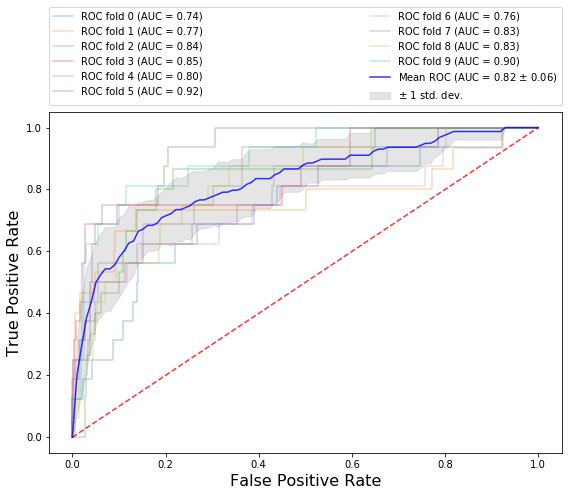

In [16]:
print ("Ploting!")
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.mean(tprs, axis = 0)
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

plt.figure(figsize=(8, 7))
# Plot each fold
for i in range(cv):
    plt.plot(fprlist[i], 
            tprlist[i], 
            alpha=0.3, 
            label = "ROC fold %d (AUC = %.2f)"%(i, aucs[i]))
# Plot the chance
plt.plot([0, 1], [0, 1], linestyle='--', color='r', alpha=.8)
# Plot the mean one
plt.plot(mean_fpr, 
        mean_tpr, 
        color='b', 
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), alpha=.8)
# Plot the variances
plt.fill_between(mean_fpr, 
                tprs_lower, 
                tprs_upper, 
                color='grey', 
                alpha=.2, label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
# plt.title('ROC for each fold')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
       ncol=2, mode="expand", borderaxespad=0.)
plt.tight_layout()

Ploting!


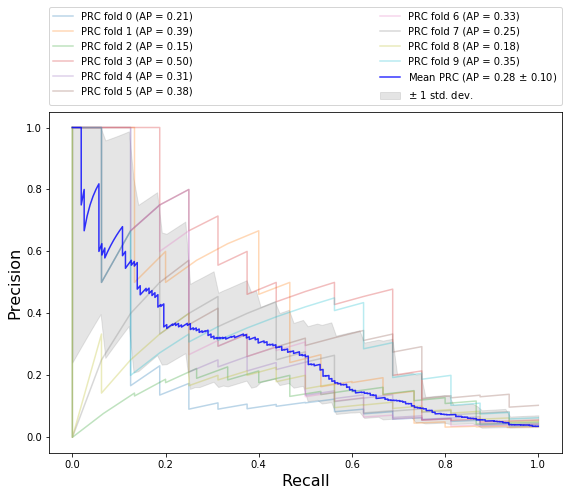

In [20]:
print ("Ploting!")
mean_rec = np.linspace(0, 1, 100)
mean_pre = np.mean(pres, axis = 0)
mean_pre2, mean_rec2, _ = precision_recall_curve(yreal, yprob)
mean_score = average_precision_score(yreal, yprob)

std_score = np.std(cv_pr)

std_pre = np.std(pres, axis=0)
pres_upper = np.minimum(mean_pre + std_pre, 1)
pres_lower = np.maximum(mean_pre - std_pre, 0)

plt.figure(figsize=(8, 7))
# Plot each fold
for i in range(cv):
    plt.plot(recalllist[i], 
            precisionlist[i],
            alpha=0.3, 
            label = "PRC fold %d (AP = %.2f)"%(i, cv_pr[i]))
# Plot the mean one
plt.plot(mean_rec2, 
        mean_pre2, 
        color='b', 
        label=r'Mean PRC (AP = %0.2f $\pm$ %0.2f)' % (mean_score, std_score), alpha=.8)
# Plot the variances
plt.fill_between(mean_rec, 
                pres_lower, 
                pres_upper, 
                color='grey', 
                alpha=.2, label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
# plt.title('ROC for each fold')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
       ncol=2, mode="expand", borderaxespad=0.)
plt.tight_layout()

In [21]:
df=pd.read_csv("ValidSet.csv")

In [22]:
df.head()

,adipose_tissue,adrenal_gland,brain,breast,colon,heart,kidney,leukocyte,liver,lung,...,TSS5k_H1hescH3k27ac,TSS5k_H1hescH3k4me1,TSS5k_H1hescH3k4me3,TSS5k_K562H3k27ac,TSS5k_K562H3k4me1,TSS5k_K562H3k4me3,cancer-miRNA_targets,miRNA_targets,hbm_total_degree,hbm_cancer-protein_degree
0,0.0000,0.000,0.00000,0.00000,0.35625,0.158333,0.00,0.000000,0.000000,0.475,...,1.26696,1.41547,1.719480,1.42071,8.05691,2.61817,0.0,0.0,68.0,0.0
1,0.0000,0.000,0.00000,0.11875,0.00000,0.000000,0.00,0.000000,0.316667,0.000,...,3.13681,2.72905,1.002450,23.38600,3.95775,2.94355,0.0,0.0,168.0,1.0
2,1.1875,1.900,0.83125,1.18750,0.71250,3.166670,0.95,0.678571,1.266670,0.475,...,1.02540,1.79405,0.988256,1.18682,1.57390,1.33713,5.0,6.0,26.0,0.0
3,0.0000,0.095,0.00000,0.00000,0.00000,0.000000,0.00,0.000000,0.000000,0.000,...,0.92500,2.01149,1.795920,1.24058,5.29147,1.63085,0.0,0.0,1038.0,0.0
4,0.0000,0.000,0.00000,0.00000,0.00000,0.000000,0.00,0.000000,0.000000,0.000,...,1.63040,2.49246,1.266500,1.51410,1.88364,1.63636,0.0,0.0,5455.0,15.0


In [23]:
X1=np.asarray(df)

In [24]:
X1

array([[0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 6.8000e+01,
        0.0000e+00],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 1.6800e+02,
        1.0000e+00],
       [1.1875e+00, 1.9000e+00, 8.3125e-01, ..., 6.0000e+00, 2.6000e+01,
        0.0000e+00],
       ...,
       [2.3750e-01, 3.8000e-01, 9.5000e-01, ..., 0.0000e+00, 1.7000e+01,
        0.0000e+00],
       [5.9375e-01, 1.9000e+00, 9.5000e-01, ..., 0.0000e+00, 5.2000e+01,
        0.0000e+00],
       [1.1875e-01, 2.8500e-01, 1.1875e+00, ..., 0.0000e+00, 2.1300e+02,
        2.0000e+00]])

In [27]:
X1 = StandardScaler().fit_transform(X1)

In [28]:
y_pred1=clf.predict(X1)

In [36]:
print (np.where(y_pred1==1)[0])

[  13   14   16   22   24   32   35   40   43   46   48   58   59   63
   69   80   85   91   99  106  107  108  115  121  127  130  133  144
  148  154  161  176  181  200  201  209  210  217  224  227  229  235
  245  246  251  256  257  263  271  273  278  283  297  298  323  340
  364  375  382  384  394  426  464  499  505  506  569  594  599  616
  623  637  650  656  672  696  717  733  744  802  811  847  868  869
  881  882  887  902  911  920  924  930  963  974  985  993  995 1009
 1019 1024 1039 1069 1112 1131 1140 1143 1157 1177 1185 1188 1214 1237
 1245 1280 1289 1291 1293 1323 1339 1365 1373 1385 1397 1415 1434 1447
 1467 1468 1481 1527 1539 1571 1596 1623 1645 1647 1651 1678 1697 1706
 1714 1725 1732 1736 1749 1753 1759 1762 1765 1772 1776 1781 1806 1807
 1819 1844 1850 1876 1877 1883 1884 1888 1896 1913 1930 1944 1947 1953
 1961 1962 1970 1976 1984 1987 2010 2025 2070 2081 2087 2088 2099 2102
 2107 2134 2146 2171 2175 2176 2190 2203 2223 2242 2265 2276 2277 2281
 2295 

In [37]:
y_prob1 = clf.predict_proba(X1)[:, 1]

In [39]:
y_prob1

array([2.4820669e-04, 3.2506242e-02, 2.6273707e-01, ..., 4.0538356e-02,
       5.3190929e-01, 7.3580234e-03], dtype=float32)